In [1]:
## import torch
import tqdm
import numpy as np
# import cv2
import imageio
from tqdm.notebook import tqdm as tqdm
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.io import imsave
from skimage.transform import warp
from skimage.measure import compare_psnr
from skimage.metrics import structural_similarity as ssim
from utils.common_utils import *
import warnings
from torchsummary import summary
from skimage import segmentation
from networks.conv_layers import *
from networks.skip import skip
from networks.unet import UNet

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

warnings.filterwarnings("ignore")

imsize = -1 

batch_size = 2

# pname = 'cactus_syn'
# start_f = 1
# fname = 'data/Ablation_data/{}/img'.format(pname)
# fgt = 'data/Ablation_data/{}/GT/{}_GT.png'.format(pname,pname)
# # fgt = 'test_data/Our/Synthetic/Set1/GT/{}.jpg'.format(pname)
# scale_factor = 1

# fresult = 'result_syn/{}_frame_{}'.format(pname,batch_size)
# if not os.path.exists(fresult):
#     os.makedirs(fresult)

# pname = 'set1'
# start_f = 1
# fname = 'data/real/iphone_turbulence_1_crop/{}'.format(pname)
# fgt = '{}/iphone_1_{:04d}.png'.format(fname,start_f)
# # fgt = 'test_data/Our/Synthetic/Set1/GT/{}.jpg'.format(pname)
# scale_factor = 1

pname = 'number'
start_f = 140051 # 140021 140036 140051
fname = 'data/real/real_hot_air/{}'.format(pname)
fgt = '{}/hotair_{:d}.png'.format(fname,start_f)
# fgt = 'test_data/Our/Synthetic/Set1/GT/{}.jpg'.format(pname)
scale_factor = 0.4

pname = 'window'
start_f = 170060 # 170031 170046 170061
fname = 'data/real/real_hot_air/{}'.format(pname)
fgt = '{}/hotair_{:d}.png'.format(fname,start_f)
# fgt = 'test_data/Our/Synthetic/Set1/GT/{}.jpg'.format(pname)
scale_factor = 0.39

pname = 'tile'
start_f = 85
fname = 'data/Fluid/Fluid_real/{}'.format(pname)
fgt = '{}/imgage_{:03d}.png'.format(fname,start_f)
# fgt = 'test_data/Our/Synthetic/Set1/GT/{}.jpg'.format(pname)
scale_factor = 0.5

pname = 'car1'
start_f = 170050 # 170020 170035 170050
fname = 'data/real/real_hot_air/{}'.format(pname)
fgt = '{}/hotair_{:d}.png'.format(fname,start_f)
# fgt = 'test_data/Our/Synthetic/Set1/GT/{}.jpg'.format(pname)
scale_factor = 0.4

pname = 'cactus_syn'
start_f = 1
fname = 'data/Ablation_data/{}/img'.format(pname)
fgt = 'data/Ablation_data/{}/GT/{}_GT.png'.format(pname,pname)
# fgt = 'test_data/Our/Synthetic/Set1/GT/{}.jpg'.format(pname)
scale_factor = 1

# num_layers = 10
#fresult = 'result_video/{}_fluid_{}_NO_K_I'.format(pname,start_f)
# fresult = 'result_iccv/{}_hotair_{}'.format(pname,start_f)
fresult = 'result_iccv/{}_air_inputNum_{}_2000'.format(pname,batch_size)
if not os.path.exists(fresult):
    os.makedirs(fresult)

cuda


# Utility Functions

In [2]:
def backwarp(tenInput, tenFlow):
    backwarp_tenGrid = {}
    if str(tenFlow.size()) not in backwarp_tenGrid:
        tenHorizontal = torch.linspace(-1.0, 1.0, tenFlow.shape[3]).view(1, 1, 1, tenFlow.shape[3]).expand(tenFlow.shape[0], -1, tenFlow.shape[2], -1)
        tenVertical = torch.linspace(-1.0, 1.0, tenFlow.shape[2]).view(1, 1, tenFlow.shape[2], 1).expand(tenFlow.shape[0], -1, -1, tenFlow.shape[3])

        backwarp_tenGrid[str(tenFlow.size())] = torch.cat([ tenHorizontal, tenVertical ], 1).cuda()
    # end

    tenFlow = torch.cat([ tenFlow[:, 0:1, :, :] / ((tenInput.shape[3] - 1.0) / 2.0), tenFlow[:, 1:2, :, :] / ((tenInput.shape[2] - 1.0) / 2.0) ], 1)

    return torch.nn.functional.grid_sample(input=tenInput, grid=(backwarp_tenGrid[str(tenFlow.size())] + tenFlow).permute(0, 2, 3, 1), mode='bilinear', padding_mode='zeros')

def backwarp_grid(tenInput, tenFlow_xy):

    return torch.nn.functional.grid_sample(input=tenInput, grid = tenFlow_xy.permute(0, 2, 3, 1), mode='bilinear', padding_mode='zeros')

def im_resize(im, scale_factor):
    width = int(im.size[1] * scale_factor)
    height = int(im.size[0] * scale_factor)
    newsize = (height,width) 
#     im1 = im.resize(newsize) 
    return im.resize(newsize) 

def visualize_rgb(warp_np):
#     warp_np = warp_np.transpose(1,2,0)
    nr = warp_np.shape[0]
    nc = warp_np.shape[1]    
    warp_np = (warp_np - np.amin(warp_np))/(np.amax(warp_np) - np.amin(warp_np))
    one_pad = np.ones((nr, nc, 1))
    out_warp_np = np.concatenate((warp_np,one_pad),axis = -1)
    return out_warp_np

def visualize_rgb_norm(warp_np):
#     warp_np = warp_np.transpose(1,2,0)
    nr = warp_np.shape[0]
    nc = warp_np.shape[1]    
#     warp_np = (warp_np - np.amin(warp_np))/(np.amax(warp_np) - np.amin(warp_np))
    one_pad = np.ones((nr, nc, 1))
    out_warp_np = np.concatenate((warp_np,one_pad),axis = -1)
    return out_warp_np

def has_file_allowed_extension(filename, extensions):
    """Checks if a file is an allowed extension.

    Args:
        filename (string): path to a file

    Returns:
        bool: True if the filename ends with a known image extension
    """
    filename_lower = filename.lower()
    return any(filename_lower.endswith(ext) for ext in extensions)

# Load Turbulence Images 

(3, 113, 109)
(2, 3, 113, 109)
(3, 113, 109)


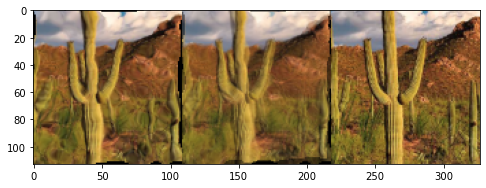

In [3]:
# Load reference GT pattern. If none, load a single turbulence image
img_gt_rgb,img_gt_np = get_image(fgt, imsize)
img_gt_np  = img_gt_np[:3,:,:]
print(img_gt_np.shape)

images = []
i = 0
# # Load turbulence image batch

extensions = ['.jpg', '.JPG', '.png', '.ppm', '.bmp', '.pgm', '.tif']
# Load image by sorted name
for target in sorted(os.listdir(fname)):
    d = os.path.join(fname, target)
    if has_file_allowed_extension(d, extensions) and i < batch_size:
#         print(d)
        i = i+1
        rgb, imgs = get_image(d, imsize)
        imgs = pil_to_np(im_resize(rgb,scale_factor))
        dim = imgs.shape[0]
        if dim ==1:
            imgs = np.concatenate((imgs, imgs,imgs), 0)        
        images.append(imgs)

# for b in range(batch_size):   
# #     d = '{}/imgage_{:03d}.png'.format(fname,b+start_f)
#     d = '{}/hotair_{:d}.png'.format(fname,b+start_f)
#     i = i+1
#     rgb, imgs = get_image(d, imsize)
#     imgs = pil_to_np(im_resize(rgb,scale_factor))
#     images.append(imgs)
             
               
images_warp_np = np.array(images)
print(images_warp_np.shape)
images_mean_np = np.mean(images_warp_np, axis = 0)
print(images_mean_np.shape)
dim, nr, nc = images_mean_np.shape
# scale_factor_gt = nr/img_gt_np.shape[1]

# imsave('{}/{}_mean_{}.png'.format(fresult,pname,batch_size), images_mean_np.transpose(1,2,0))


# img_gt_np = images_mean_np

# if dim>1:
#     img_gt_np = cv2.resize(img_gt_np.transpose(1,2,0), dsize=(nc, nr), interpolation=cv2.INTER_AREA).transpose(2,0,1)
#     print(images_warp_np.shape)
# else:
#     img_gt_np = cv2.resize(img_gt_np.transpose(1,2,0), dsize=(nc, nr), interpolation=cv2.INTER_AREA)
#     print(images_warp_np.shape)

# img_gt_np = img_gt_np.transpose(2,0,1)
out_imshow = np.concatenate([images_warp_np[0].transpose(1,2,0),images_mean_np.transpose(1,2,0),img_gt_np.transpose(1,2,0)], axis = 1)
plt.figure(figsize=(8,5))
plt.imshow(out_imshow)
plt.show()

# Setup GridNet

In [4]:
class GaussianFourierFeatureTransform_B(torch.nn.Module):
    """
    An implementation of Gaussian Fourier feature mapping.

    "Fourier Features Let Networks Learn High Frequency Functions in Low Dimensional Domains":
       https://arxiv.org/abs/2006.10739
       https://people.eecs.berkeley.edu/~bmild/fourfeat/index.html

    Given an input of size [batches, num_input_channels, width, height],
     returns a tensor of size [batches, mapping_size*2, width, height].
    """

    def __init__(self, num_input_channels, B, mapping_size=256, scale=10):
        super().__init__()

        self._num_input_channels = num_input_channels
        self._mapping_size = mapping_size
        self._B = B*scale
#         self._B = torch.load('{}/{}_tensor_B.pt'.format(fresult,pname))

    def forward(self, x):
        assert x.dim() == 4, 'Expected 4D input (got {}D input)'.format(x.dim())

        batches, channels, width, height = x.shape

        assert channels == self._num_input_channels,\
            "Expected input to have {} channels (got {} channels)".format(self._num_input_channels, channels)

        # Make shape compatible for matmul with _B.
        # From [B, C, W, H] to [(B*W*H), C].
        x = x.permute(0, 2, 3, 1).reshape(batches * width * height, channels)

        x = x @ self._B.to(x.device)

        # From [(B*W*H), C] to [B, W, H, C]
        x = x.view(batches, width, height, self._mapping_size)
        # From [B, W, H, C] to [B, C, W, H]
        x = x.permute(0, 3, 1, 2)

        x = 2 * np.pi * x
        return torch.cat([torch.sin(x), torch.cos(x)], dim=1)

In [5]:
# Generate straight grid batch for shape image
xy_grid_batch = []
coords_x = np.linspace(-1, 1, nc)
coords_y = np.linspace(-1, 1, nr)
xy_grid = np.stack(np.meshgrid(coords_x, coords_y), -1)

xy_grid_var = np_to_torch(xy_grid.transpose(2,0,1)).type(dtype).cuda()
xy_grid_batch_var = xy_grid_var.repeat(batch_size, 1, 1, 1)
print(xy_grid_batch_var.shape)

torch.Size([2, 2, 113, 109])


In [6]:
model_grid = conv_layers(256,3)
model_grid = model_grid.type(dtype)
# print(model_grid)
summary(model_grid,(256, nr, nc))

# load saved B or generate a new B
# B_var = torch.load('result/Pattern4/Pattern4_tensor_B.pt')
torch.manual_seed(0)

B_var = torch.randn(2,128)
print(B_var.shape)

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 256, 113, 109]       65,792
├─ReLU: 1-2                              [-1, 256, 113, 109]       --
├─BatchNorm2d: 1-3                       [-1, 256, 113, 109]       512
├─Conv2d: 1-4                            [-1, 256, 113, 109]       65,792
├─ReLU: 1-5                              [-1, 256, 113, 109]       --
├─Conv2d: 1-6                            [-1, 256, 113, 109]       65,792
├─ReLU: 1-7                              [-1, 256, 113, 109]       --
├─Conv2d: 1-8                            [-1, 3, 113, 109]         771
├─Sigmoid: 1-9                           [-1, 3, 113, 109]         --
Total params: 198,659
Trainable params: 198,659
Non-trainable params: 0
Total mult-adds (G): 2.43
Input size (MB): 12.03
Forward/backward pass size (MB): 96.51
Params size (MB): 0.76
Estimated Total Size (MB): 109.29
torch.Size([2, 128])


# Setup Vectornet 

In [7]:
# Use the skip net as grid deformor

input_depth_warp = 8
# INPUT = 'noise'
pad = 'reflection'

# model_vec = skip( input_depth_warp, 2,
#             num_channels_down = [128, 128, 128, 128, 128],   
#             num_channels_up   = [128, 128, 128, 128, 128],
#             num_channels_skip = [16, 16, 16, 16, 16],
#             upsample_mode='bilinear',
#             need_sigmoid=False, need_tanh=True, need_bias=True, pad=pad, act_fun='LeakyReLU')
                                       
# Generate random noise as input of vectornet
# net_input_warp = get_noise_batch(batch_size, input_depth_warp, INPUT, (nr, nc)).type(dtype).detach()
# #net_input_warp_saved = net_input_warp.detach().clone()

# -------------------------------------Use 10 grid-deform networks ---------------------------
model_vec = []
# for i in range(batch_size):
#     model_vec.append(conv_layers(256,2, need_sigmoid = False, need_tanh = True).to(device))

# sum1 = summary(model_vec[0],(256, nr, nc))
for i in range(batch_size):
    model_vec.append(conv_layers(2,2, need_sigmoid = False, need_tanh = True).to(device))

sum1 = summary(model_vec[0],(2, nr, nc))

# -------------------------------------Use 1 grid-deform networks ---------------------------
# model_vec = conv_layers(2,2, need_sigmoid = False, need_tanh = True)

# model_vec = skip(2, 2,
#             num_channels_down = [128, 128, 128, 128, 128],   
#             num_channels_up   = [128, 128, 128, 128, 128],
#             num_channels_skip = [16, 16, 16, 16, 16],
#             upsample_mode='bilinear',
#             need_sigmoid=False, need_tanh=True, need_bias=True, pad=pad, act_fun='LeakyReLU')

# model_vec = model_vec.type(dtype)
# # sum1 = summary(model_vec,(256, nr, nc))
# sum1 = summary(model_vec,(2, nr, nc))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 256, 113, 109]       768
├─ReLU: 1-2                              [-1, 256, 113, 109]       --
├─BatchNorm2d: 1-3                       [-1, 256, 113, 109]       512
├─Conv2d: 1-4                            [-1, 256, 113, 109]       65,792
├─ReLU: 1-5                              [-1, 256, 113, 109]       --
├─Conv2d: 1-6                            [-1, 256, 113, 109]       65,792
├─ReLU: 1-7                              [-1, 256, 113, 109]       --
├─Conv2d: 1-8                            [-1, 2, 113, 109]         514
├─Tanh: 1-9                              [-1, 2, 113, 109]         --
Total params: 133,378
Trainable params: 133,378
Non-trainable params: 0
Total mult-adds (G): 1.63
Input size (MB): 0.09
Forward/backward pass size (MB): 96.41
Params size (MB): 0.51
Estimated Total Size (MB): 97.02


# Setup Initialization of GridNet

In [8]:
# The input turbulent images

# The frequence bandwith for the turbulence field
# For air turbulence
FB_img = 8
FB_turb = 0.1

# For fluid
# FB_img = 10
# FB_turb = 0.02


vec_scale = 1.1

reg_noise_std = 1./30. # set to 1./30 works fine

img_gt_batch_var = torch.from_numpy(images_warp_np).type(dtype).cuda()
straight_grid_input = GaussianFourierFeatureTransform_B(2, B_var, 128, FB_img)(xy_grid_batch_var)
# -------------------------------SETUP Grid deformer---------------------------------------------------
# straight_grid_input_single = GaussianFourierFeatureTransform_B(2, B_var, 128, FB_turb)(xy_grid_var)
# grid_input_single = straight_grid_input_single.detach().clone()
straight_grid_input_gd = GaussianFourierFeatureTransform_B(2, B_var, 128, FB_turb)(xy_grid_batch_var)
grid_input_single_gd = xy_grid_var.detach().clone()
# grid_input_gd = straight_grid_input_gd.detach().clone()
grid_input_gd = xy_grid_batch_var.detach().clone()
# -------------------------------------------------------------------------------------------------------
grid_input = straight_grid_input.detach().clone()
# print(straight_grid_input_gd.shape)

In [9]:
model_params_list = [{'params':model_vec[i].parameters()} for i in range(batch_size)]
# model_params_list = []
# model_params_list.append({'params':model_vec.parameters()})
model_params_list.append({'params':model_grid.parameters()})

# print(model_params_list)

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Epoch 0, loss = 0.732


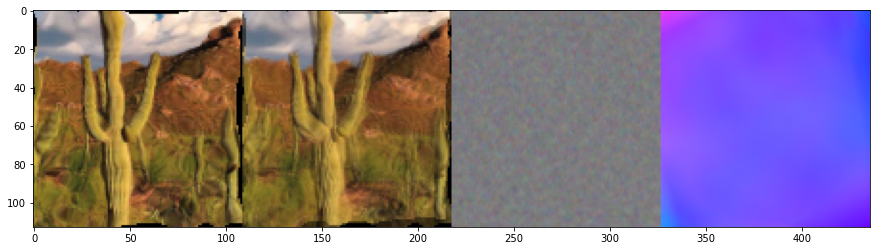

Epoch 100, loss = 0.130


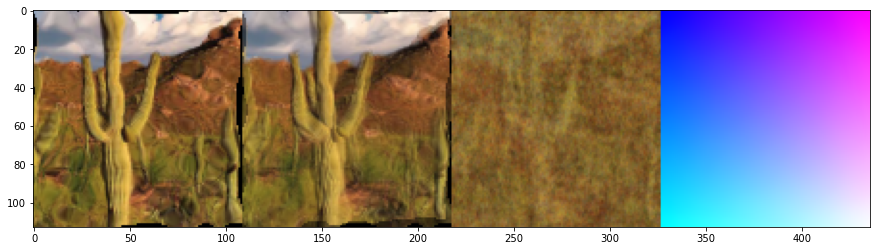

Epoch 200, loss = 0.077


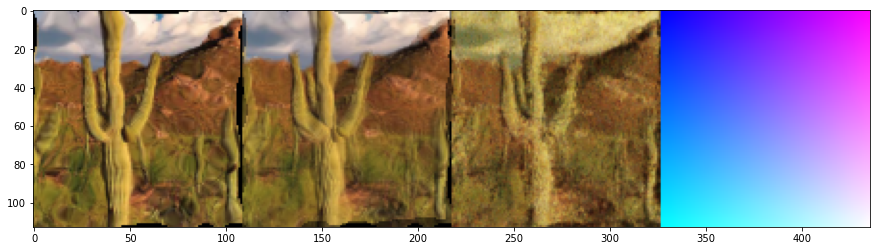

Epoch 300, loss = 0.057


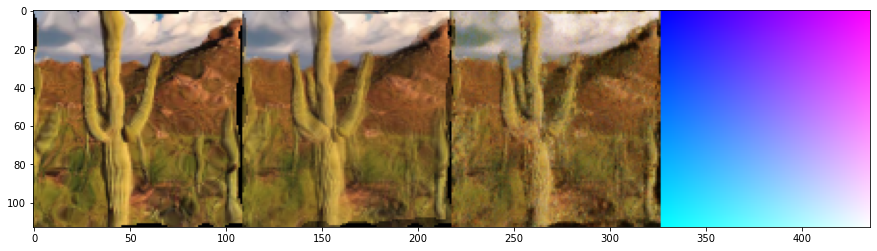

Epoch 400, loss = 0.054


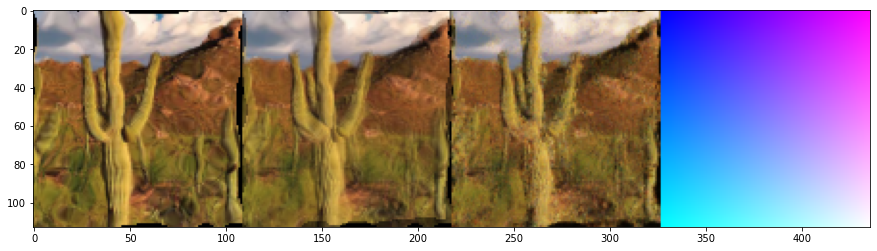

Epoch 500, loss = 0.053


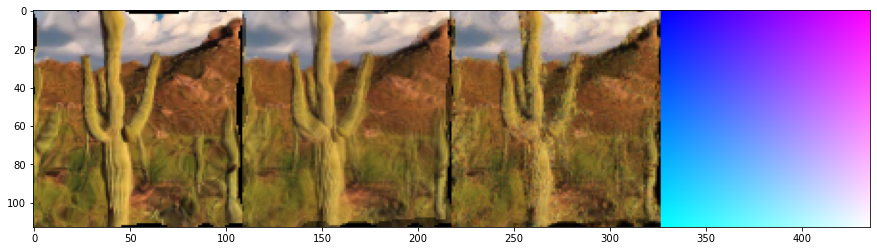

Epoch 600, loss = 0.053


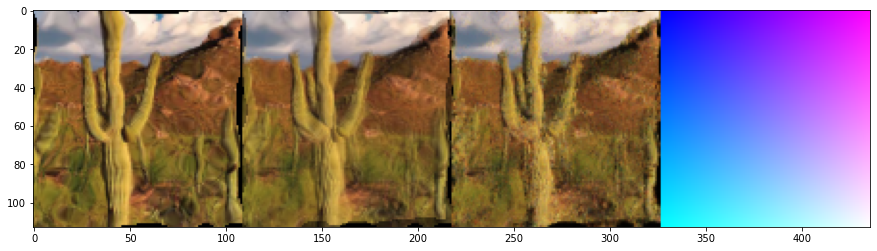

Epoch 700, loss = 0.053


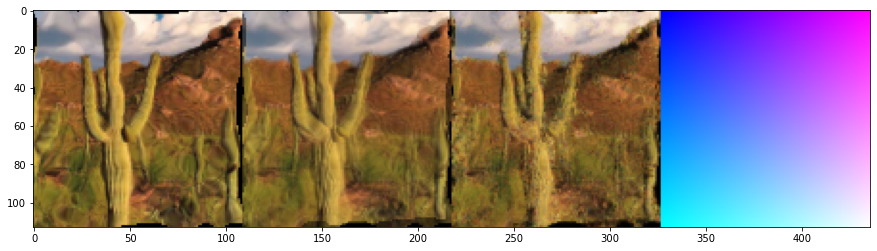

Epoch 800, loss = 0.053


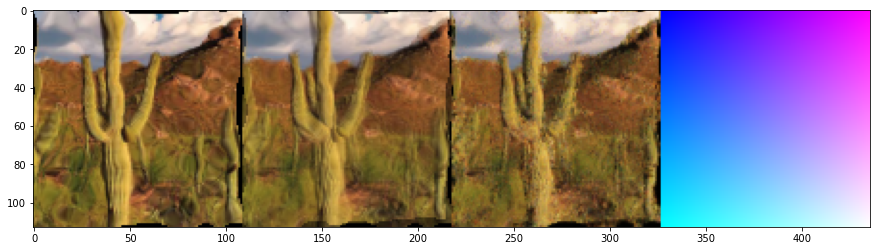

Epoch 900, loss = 0.053


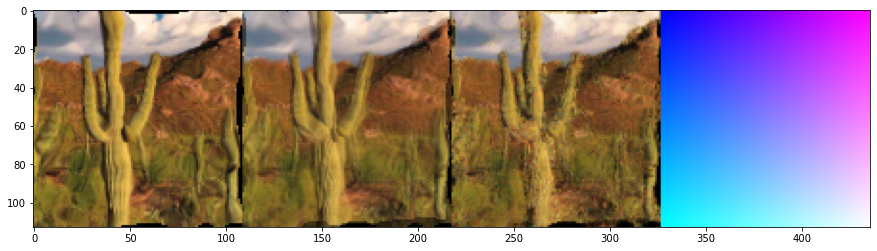

In [10]:
optimizer = torch.optim.Adam(model_params_list, lr=1e-4)

num_iter_i = 1000

# imsave('{}/{}_turb_img_frame_{}.png'.format(fresult,pname,0), images_warp_np[0].transpose(1,2,0))
imsave('{}/{}_avg_img_{}.png'.format(fresult,pname,batch_size), images_mean_np.transpose(1,2,0))
for epoch in tqdm(range(num_iter_i)): 
    
    optimizer.zero_grad()
# -------------------------------SETUP Grid deformer---------------------------------------------------    
    refined_xy = []
    for b in range(batch_size):
#         vec_input = grid_input_single
        vec_input = grid_input_single_gd
        refined_xy.append(model_vec[b](vec_input))
    refined_xy = vec_scale*torch.cat(refined_xy)
# -------------------------------------------------------------------------------------------------------    
#     refined_xy = model_vec(grid_input_gd)
#     refined_xy = vec_scale*refined_xy
# -------------------------------------------------------------------------------------------------------
                
    generated =  model_grid(grid_input)  

    loss = torch.nn.functional.l1_loss(img_gt_batch_var, generated)
    loss += torch.nn.functional.l1_loss(xy_grid_batch_var, refined_xy)    

    loss.backward()
    optimizer.step()   

    if epoch % 100 == 0:
        print('Epoch %d, loss = %.03f' % (epoch, float(loss)))
        out_img = generated[0].detach().cpu().numpy().transpose(1,2,0)
        pred_xy = refined_xy[0].detach().cpu().numpy().transpose(1,2,0)
        out_imshow = np.concatenate([images_warp_np[0].transpose(1,2,0),images_mean_np.transpose(1,2,0),out_img,visualize_rgb(pred_xy)], axis = 1)
        plt.figure(figsize=(15,5))       
        plt.imshow(np.clip(out_imshow,0,1))
        plt.show()                


In [11]:
imsave('{}/{}_ini_{}_{}.png'.format(fresult,pname,FB_img,batch_size), out_img)  

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


In [12]:
torch.save(model_grid, '{}/{}_gridnet_initalweights_scale_{}_noKG_{}_10warp_FB_{}_{}.pth'.format(fresult,pname,scale_factor,FB_img,FB_turb,start_f))
torch.save(model_vec, '{}/{}_vecnet_initalweights_scale_{}_noKG_{}_10warp_FB_{}_{}.pth'.format(fresult,pname,scale_factor,FB_img,FB_turb,start_f))
# model_grid = torch.load('{}/{}_gridnet_initalweights_scale_{}_pipelineB_{}_10warp_FB_{}.pth'.format(fresult,pname,scale_factor,FB_img,FB_turb)).type(dtype).cuda()
# model_vec = torch.load('{}/{}_vecnet_initalweights_scale_{}_pipelineB_{}_10warp_FB_{}.pth'.format(fresult,pname,scale_factor,FB_img,FB_turb))

Epoch 0, loss = 0.116, psnr_sharp = 18.261, psnr_turb = 20.216


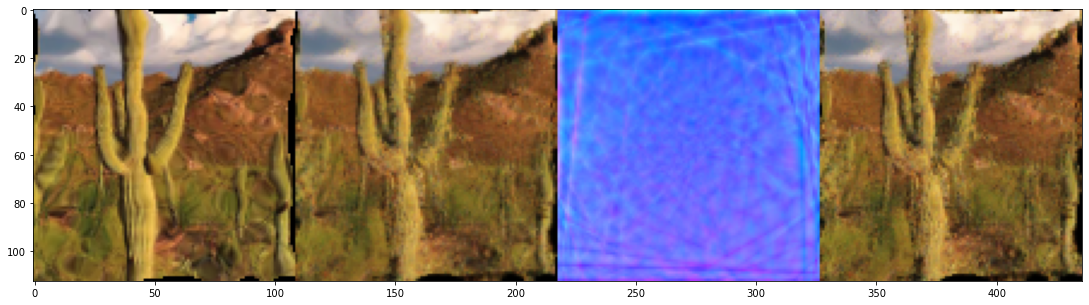

Epoch 100, loss = 0.080, psnr_sharp = 18.479, psnr_turb = 23.466


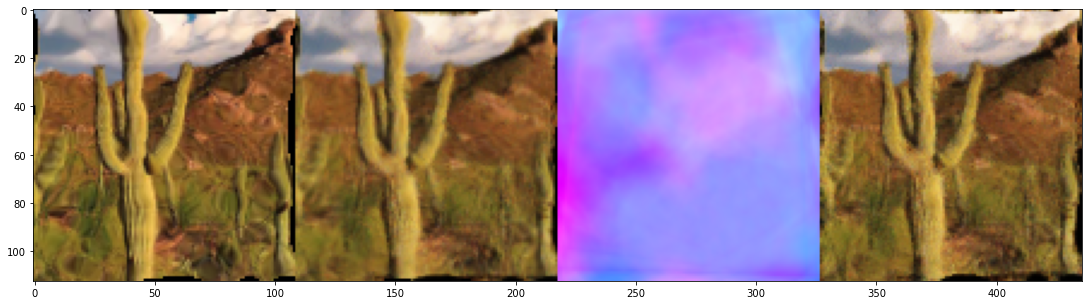

Epoch 200, loss = 0.064, psnr_sharp = 18.310, psnr_turb = 24.665


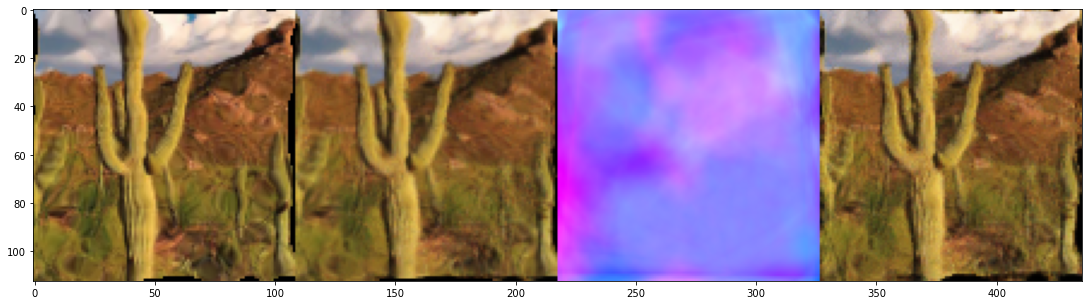

Epoch 300, loss = 0.058, psnr_sharp = 18.150, psnr_turb = 25.383


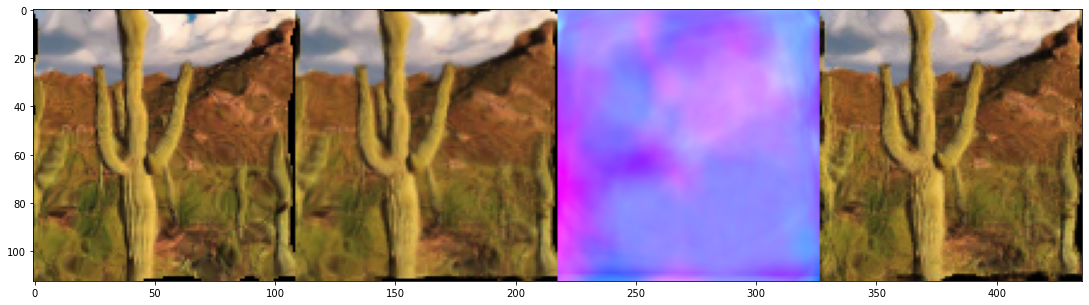

Epoch 400, loss = 0.055, psnr_sharp = 18.031, psnr_turb = 25.835


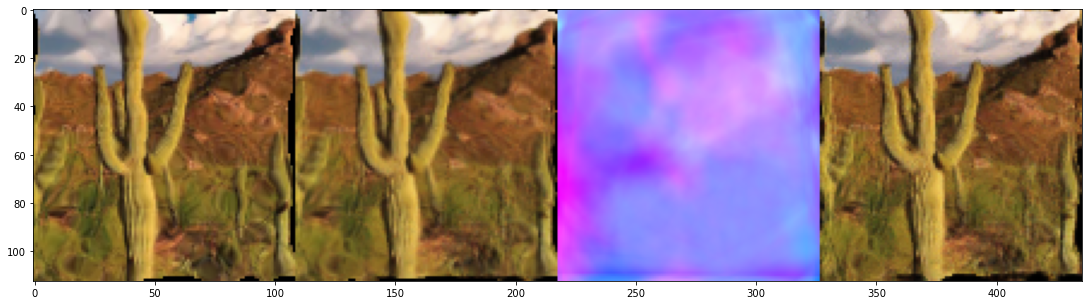

Epoch 500, loss = 0.052, psnr_sharp = 17.943, psnr_turb = 26.263


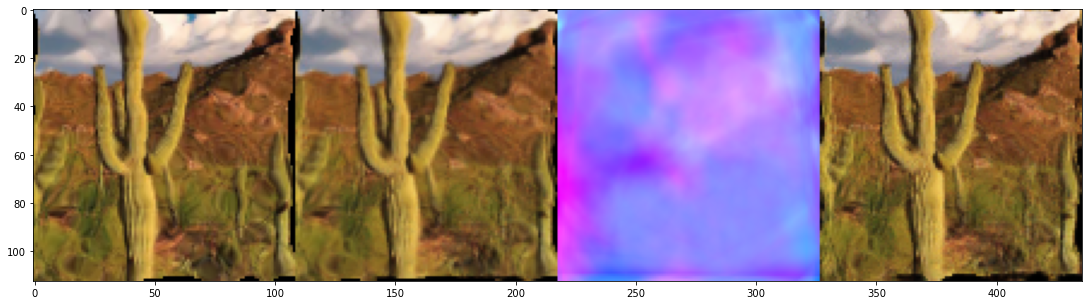

Epoch 600, loss = 0.049, psnr_sharp = 17.880, psnr_turb = 26.536


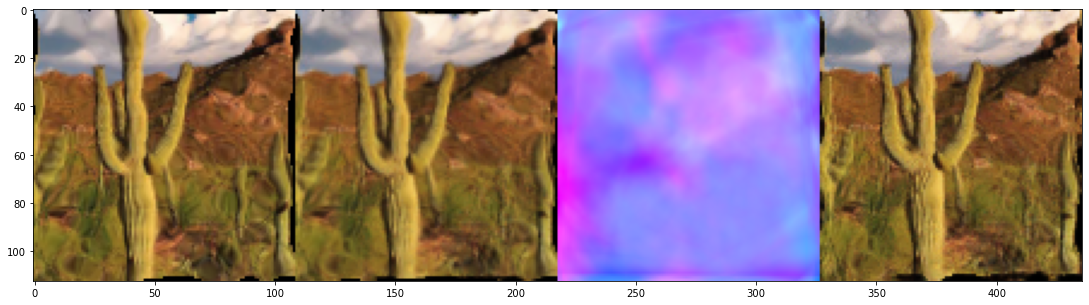

Epoch 700, loss = 0.046, psnr_sharp = 17.838, psnr_turb = 26.654


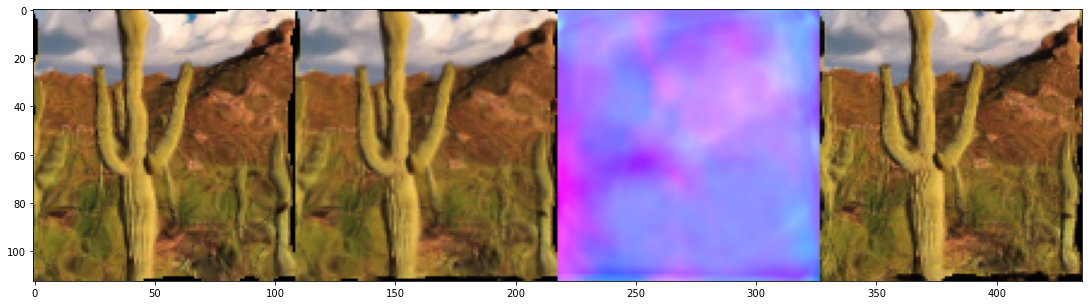

Epoch 800, loss = 0.046, psnr_sharp = 17.805, psnr_turb = 26.582


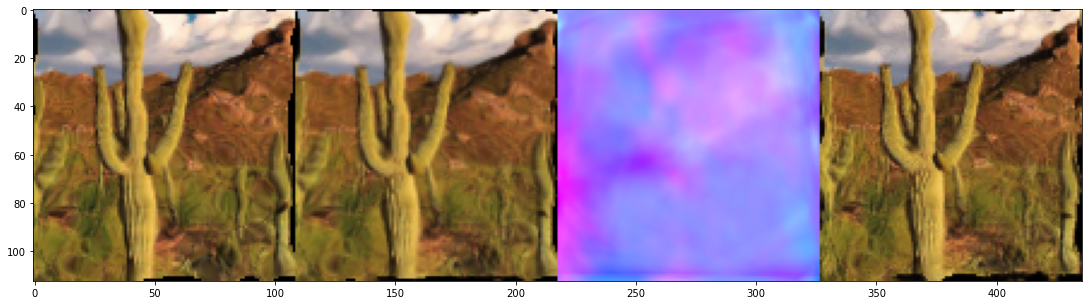

Epoch 900, loss = 0.045, psnr_sharp = 17.775, psnr_turb = 26.599


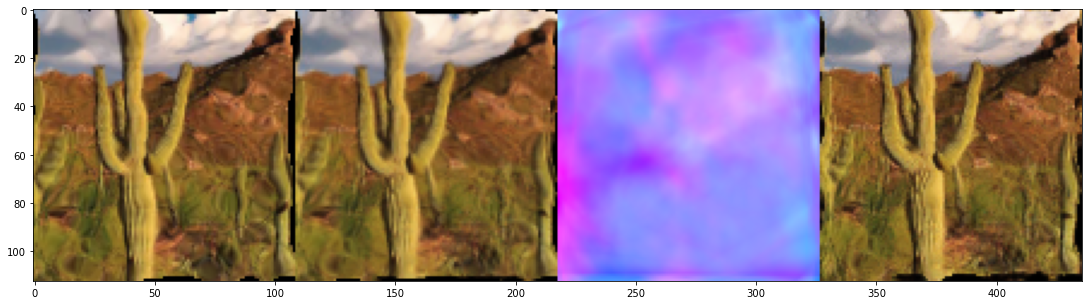

In [13]:
num_iter = 1000
reg_noise_std = 1./30

# the reference frame in the plot
i = 0

loss_arr = torch.zeros(num_iter)
psnr_arr_sharp = torch.zeros(num_iter)
psnr_arr_turb = torch.zeros(num_iter)
ssim_arr_sharp = torch.zeros(num_iter)
ssim_arr_turb = torch.zeros(num_iter)
# seed = torch.seed()

optimizer = torch.optim.Adam(model_params_list, lr=1e-4)

for epoch in tqdm(range(num_iter)):
      
    optimizer.zero_grad()   
    
# -------------------------------SETUP Grid deformer---------------------------------------------------
    refined_xy = []
    for b in range(batch_size):
#         vec_input = grid_input_single 
        vec_input = grid_input_single_gd 
        refined_xy.append(model_vec[b](vec_input))
    
    refined_xy = vec_scale*torch.cat(refined_xy)
# -------------------------------------------------------------------------------------------------------
#     refined_xy = model_vec(grid_input_gd)
#     refined_xy = vec_scale*refined_xy
# -------------------------------------------------------------------------------------------------------
    refined_warp = refined_xy - xy_grid_batch_var
    refined_uv = torch.cat(((nc - 1.0)*refined_warp[:, 0:1, :, :]/2 , (nr - 1.0)*refined_warp[:, 1:2, :, :]/2), 1)
    
    # Get mask for the warp field
    mask_u1 = (refined_xy[:,0:1,:,:] > -1).float() * 1
    mask_u2 = (refined_xy[:,0:1,:,:] < 1).float() * 1 
    mask_v1 = (refined_xy[:,1:2,:,:] > -1).float() * 1
    mask_v2 = (refined_xy[:,1:2,:,:] < 1).float() * 1  
    mask = mask_u1*mask_u2*mask_v1*mask_v2
    
    # predict sharp image using straight grid
    sharp_imgs_predict = model_grid(grid_input)
    
    # predict turbulent image using forward mapping
    refined_turb_imgs = backwarp_grid(sharp_imgs_predict,refined_xy)
    
    # predict turbulent images using sampling grid
    generated_turb_imgs = model_grid(GaussianFourierFeatureTransform_B(2, B_var, 128, FB_img)(refined_xy))

    # loss function
    loss = torch.nn.functional.l1_loss(generated_turb_imgs*mask,img_gt_batch_var*mask) 
    loss += torch.nn.functional.l1_loss(refined_turb_imgs*mask,img_gt_batch_var*mask)  
    loss += torch.nn.functional.l1_loss(generated_turb_imgs*mask,refined_turb_imgs*mask)
    
#     loss += torch.nn.functional.l1_loss(img_gt_batch_var*mask, sharp_imgs_predict*mask)
#     loss += torch.nn.functional.l1_loss(xy_grid_batch_var, refined_xy)    
    
    loss_arr[epoch] = loss
    psnr_arr_sharp[epoch] = compare_psnr(img_gt_np, sharp_imgs_predict[i].detach().cpu().numpy()) 
    psnr_arr_turb[epoch]   = compare_psnr(images_warp_np[i], generated_turb_imgs[i].detach().cpu().numpy()) 
    ssim_arr_sharp[epoch] = ssim(img_gt_np.transpose(1,2,0), sharp_imgs_predict[i].detach().cpu().numpy().transpose(1,2,0),multichannel=True) 
    ssim_arr_turb[epoch]   = ssim(images_warp_np[i].transpose(1,2,0), generated_turb_imgs[i].detach().cpu().numpy().transpose(1,2,0),multichannel=True)     

    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print('Epoch %d, loss = %.03f, psnr_sharp = %.03f, psnr_turb = %.03f' % (epoch, float(loss), float(psnr_arr_sharp[epoch]), float(psnr_arr_turb[epoch])))
        
        out_img = refined_turb_imgs[i]*mask[i]
        out_img = out_img.detach().cpu().numpy().transpose(1,2,0)
        sharp_img = sharp_imgs_predict[i].detach().cpu().numpy().transpose(1,2,0)
        warp_img= refined_uv[i].detach().cpu().numpy().transpose(1,2,0)
        out_target = images_warp_np[i].transpose(1,2,0)

        out_imshow = np.concatenate([out_target,out_img,visualize_rgb(warp_img),sharp_img], axis = 1)
        plt.figure(figsize=(20,5))       
        plt.imshow(np.clip(out_imshow,0,1))
        plt.show()

0.044228386133909225


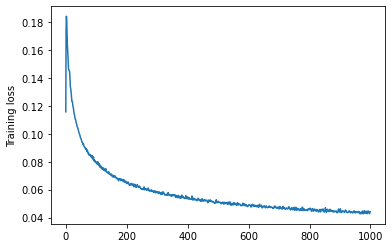

In [14]:
print(float(loss))
loss_arr_np = loss_arr.detach().cpu().numpy()
plt.plot(loss_arr_np[:])
plt.ylabel('Training loss')
plt.show()


In [15]:
torch.save(model_vec, '{}/{}_vectornet_final_wIni_10warpnet_noKG_{}_{}.pth'.format(fresult,pname,FB_img,batch_size))
torch.save(model_grid, '{}/{}_gridnet_final_wIni_10warpnet_noKG_{}_{}.pth'.format(fresult,pname,FB_img,batch_size))
torch.save(loss_arr, '{}/{}_loss_final_wIni_10warpnet_noKG_{}_{}pth'.format(fresult,pname,FB_img,batch_size))
torch.save(psnr_arr_sharp, '{}/{}_psnr_sharp_final_wIni_10warpnet_noKG_{}_{}.pth'.format(fresult,pname,FB_img,batch_size))
torch.save(psnr_arr_turb, '{}/{}_psnr_turb_final_wIni_10warpnet_noKG_{}_{}.pth'.format(fresult,pname,FB_img,batch_size))
torch.save(ssim_arr_sharp, '{}/{}_ssim_sharp_final_wIni_10warpnet_noKG_{}_{}.pth'.format(fresult,pname,FB_img,batch_size))
torch.save(ssim_arr_turb, '{}/{}_ssim_turb_final_wIni_10warpnet_noKG_{}_{}.pth'.format(fresult,pname,FB_img,batch_size))

# Test

PSNR: 17.75108074812721, SSIM: 0.5560155743889653


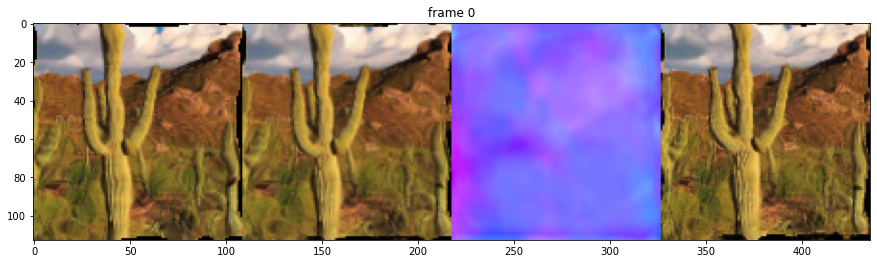

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


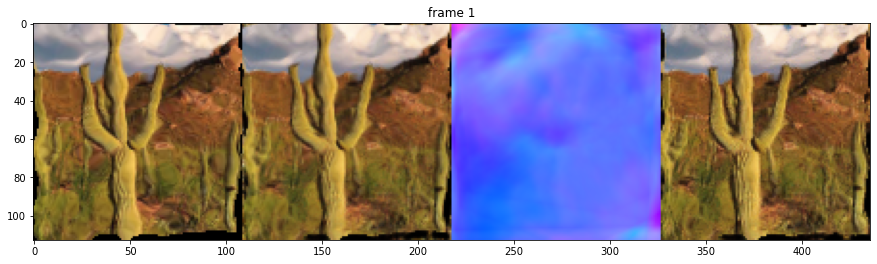

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


In [16]:
# model_vec = torch.load('{}/{}_vectornet_final_wIni_10warpnet_scale_{}_pipelineB.pth'.format(fresult,pname,scale))
# model_grid = torch.load('{}/{}_gridnet_final_wIni_10warpnet_scale_{}_pipelineB.pth'.format(fresult,pname,scale)).type(dtype).cuda()

fresult = '{}/{}/'.format(fresult,batch_size)
if not os.path.exists(fresult):
    os.makedirs(fresult)
    
# -------------------------------SETUP Grid deformer---------------------------------------------------    
refined_xy = []
for b in range(batch_size):
    refined_xy.append(model_vec[b](grid_input_single_gd))
#     refined_xy.append(model_vec[b](xy_grid_var).type(dtype).cuda())
refined_xy = vec_scale*torch.cat(refined_xy)
# -------------------------------------------------------------------------------------------------------
# refined_xy = model_vec(grid_input_gd)
# refined_xy = vec_scale*refined_xy
# -------------------------------------------------------------------------------------------------------

refined_warp = refined_xy - xy_grid_batch_var
refined_uv = torch.cat([(nc - 1.0)*refined_warp[:, 0:1, :, :]/2 , (nr - 1.0)*refined_warp[:, 1:2, :, :]/2], 1)

refined_uv -= refined_uv.min()
refined_uv /= refined_uv.max()
# refined_uv = refined_uv*mask


generated_turb_imgs = model_grid(GaussianFourierFeatureTransform_B(2, B_var, 128, FB_img)(refined_xy))

sharp_imgs_predict = model_grid(grid_input)

psnr_arr= compare_psnr(img_gt_np, sharp_imgs_predict[0].detach().cpu().numpy()) 
ssim_arr = ssim(img_gt_np.transpose(1,2,0), sharp_imgs_predict[0].detach().cpu().numpy().transpose(1,2,0),multichannel=True) 

print('PSNR: {}, SSIM: {}'.format(psnr_arr,ssim_arr))
for j in range(batch_size):
#     out_img = generated_turb_imgs[j].detach().cpu().numpy().transpose(1,2,0)
    out_img = generated_turb_imgs[j].detach().cpu().numpy().transpose(1,2,0)
    sharp_img = sharp_imgs_predict[j].detach().cpu().numpy().transpose(1,2,0)
    warp_img= refined_uv[j].detach().cpu().numpy().transpose(1,2,0)
#         warp_gt = warps_gt_batch_np[i]

    out_target = img_gt_batch_var[j].detach().cpu().numpy().transpose(1,2,0)    
    out_imshow = np.concatenate([out_target,out_img,visualize_rgb_norm(warp_img),sharp_img], axis = 1)
    plt.figure(figsize=(15,5))
    plt.title('frame {}'.format(j))
    plt.imshow(out_imshow)
    plt.show()
    
    imsave('{}/{}_turb_img_gt_{}_FB_{}.png'.format(fresult,pname,j+start_f,FB_img), out_target)
    imsave('{}/{}_turb_img_{}_FB_{}.png'.format(fresult,pname,j+start_f,FB_img), out_img)
    imsave('{}/{}_sharp_img_{}_FB_{}.png'.format(fresult,pname,j+start_f,FB_img), sharp_img) 
    imsave('{}/{}_warp_img_{}_FB_{}.png'.format(fresult,pname,j+start_f,FB_img), visualize_rgb_norm(warp_img))     

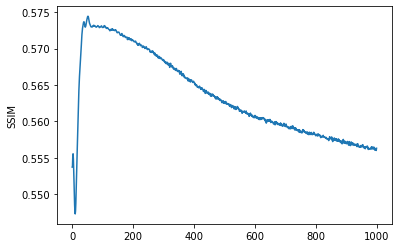

In [17]:
# print(float(loss))
ssim_arr_sharp_np = ssim_arr_sharp.detach().cpu().numpy()
plt.plot(ssim_arr_sharp_np[:])
plt.ylabel('SSIM')
plt.show()

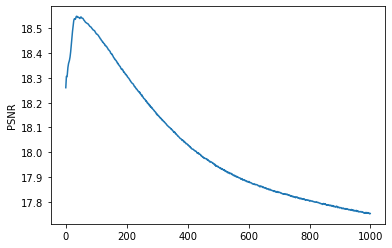

In [18]:
psnr_arr_sharp_np = psnr_arr_sharp.detach().cpu().numpy()
plt.plot(psnr_arr_sharp_np[:])
plt.ylabel('PSNR')
plt.show()

In [19]:
max_index_psnr = np.argmax(psnr_arr_sharp_np)
max_index_ssim = np.argmax(ssim_arr_sharp_np)
print(max(psnr_arr_sharp_np),max(ssim_arr_sharp_np))
print(max_index_psnr,max_index_ssim)

18.549425 0.5744497
36 52
